# Projeto 2 - CDados

### Autores: Diego Guimarães Nuñez, Felipe Bakowski Nantes de Souza, Gustavo de Lima Mota

### Tema: Conseguimos prever o número de homicídios totais das cidades que não são capital por ano, no estado de São Paulo?

### Features: IDH por município, Proporção de crianças (6-14 anos) fora da escola, Proporção de vulnerabilidade socioeconêmica, Proporção de pessoas sem água e esgoto, e Índice de Gini por município.

In [1]:
import basedosdados as bd
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import display
import seaborn as sns

### Baixando as bases de dados utilizadas no projeto:

In [2]:
homicidio = bd.read_table(dataset_id='br_sp_gov_ssp',
table_id='ocorrencias_registradas',
billing_project_id="cdadosp2-404421")

Downloading: 100%|██████████| 153876/153876 [00:31<00:00, 4818.91rows/s]


In [3]:
homicidio

,ano,mes,id_municipio,regiao_ssp,homicidio_doloso,numero_de_vitimas_em_homicidio_doloso,homicidio_doloso_por_acidente_de_transito,numero_de_vitimas_em_homicidio_doloso_por_acidente_de_transito,homicidio_culposo_por_acidente_de_transito,homicidio_culposo_outros,...,total_de_estupro,estupro,estupro_de_vulneravel,total_de_roubo_outros,roubo_outros,roubo_de_veiculo,roubo_a_banco,roubo_de_carga,furto_outros,furto_de_veiculo
0,2002,1,3500105,Presidente Prudente,0,0,0,0,0,0,...,0,<NA>,<NA>,0,<NA>,0,0,0,21,0
1,2002,2,3500105,Presidente Prudente,0,0,0,0,0,0,...,0,<NA>,<NA>,0,<NA>,0,0,0,32,0
2,2002,3,3500105,Presidente Prudente,0,0,0,0,0,0,...,0,<NA>,<NA>,0,<NA>,0,0,0,36,0
3,2002,4,3500105,Presidente Prudente,0,0,0,0,0,0,...,0,<NA>,<NA>,1,<NA>,0,0,0,45,0
4,2002,5,3500105,Presidente Prudente,0,0,0,0,0,0,...,0,<NA>,<NA>,1,<NA>,0,0,0,35,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
153871,2018,8,3500204,São José do Rio Preto,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,5,0
153872,2018,9,3500204,São José do Rio Preto,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2,0
153873,2018,10,3500204,São José do Rio Preto,0,0,0,0,0,0,...,0,0,0,1,1,0,0,0,2,0
153874,2018,11,3500204,São José do Rio Preto,0,0,0,0,0,0,...,0,0,0,1,1,0,0,0,2,0


In [4]:
ivs = bd.read_table(dataset_id='br_ipea_avs',
table_id='municipio',
billing_project_id="cdadosp2-404421")

Downloading: 100%|██████████| 319681/319681 [06:24<00:00, 830.57rows/s] 


In [5]:
ivs # colunas que serão usadas para feature: "ivs", "ivs_infraestrutura_urbana", "ivs_capital_humano" e "ivs_renda_trabalho"
# índice de vulnerabilidade social.

,ano,sigla_uf,id_municipio,raca_cor,sexo,localizacao,ivs,ivs_infraestrutura_urbana,ivs_capital_humano,ivs_renda_trabalho,...,populacao_15_mais,populacao_15_17,populacao_15_24,populacao_16_18,populacao_18_mais,populacao_18_20,populacao_18_24,populacao_19_21,populacao_25_mais,populacao_65_mais
0,2000,DF,5300108,branco,total,total,0.330,0.422,0.292,0.275,...,721889,57931,213070,62981,663959,69468,155139,68446,508819,39843
1,2000,DF,5300108,branco,total,rural,NaN,NaN,0.444,0.366,...,23359,2193,7074,2286,21166,2151,4881,2016,16285,1228
2,2000,DF,5300108,branco,total,urbano,0.326,0.420,0.287,0.271,...,698531,55738,205996,60695,642793,67317,150259,66430,492534,38615
3,2000,DF,5300108,total,total,total,0.383,0.434,0.378,0.337,...,1466629,127262,459221,136437,1340805,147258,331959,145436,1007901,67515
4,2000,DF,5300108,total,total,rural,NaN,NaN,0.542,0.411,...,59657,5502,18942,5875,54155,5874,13440,5720,40715,2358
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
319676,2010,SP,3518701,negro,mulher,rural,NaN,NaN,NaN,NaN,...,9,0,0,0,9,0,0,0,9,0
319677,2010,SP,3531100,negro,mulher,rural,NaN,NaN,NaN,NaN,...,10,0,0,0,10,0,0,0,10,0
319678,2010,SP,3533403,negro,mulher,rural,NaN,NaN,NaN,NaN,...,21,0,11,0,21,0,11,0,10,0
319679,2010,SP,3502507,negro,mulher,rural,NaN,NaN,NaN,NaN,...,79,0,0,0,79,0,0,0,79,0


In [6]:
ivs.columns

Index(['ano', 'sigla_uf', 'id_municipio', 'raca_cor', 'sexo', 'localizacao',
       'ivs', 'ivs_infraestrutura_urbana', 'ivs_capital_humano',
       'ivs_renda_trabalho', 'idhm', 'idhm_l', 'idhm_e', 'idhm_r',
       'idhm_subescolaridade', 'idhm_subfrequencia', 'prosperidade_social',
       'proporcao_vulnerabilidade_socioeconomica', 'propocao_energia_eletrica',
       'proporcao_domicilio_densidade', 'proporcao_sem_agua_esgoto',
       'proporcao_sem_coleta', 'renda_per_capita', 'renda_media_18_mais',
       'proporcao_sem_renda_18_mais', 'renda_trabalho',
       'renda_per_capita_vulneravel', 'proporcao_vulneravel',
       'populacao_vulneravel_15_24', 'proporcao_vulneravel_dependente_idoso',
       'populacao_vulneravel_e_idoso', 'razao_dependencia',
       'fecundidade_total', 'taxa_envelhecimento', 'mortalidade_1_menos',
       'proporcao_mortalidade_5_menos', 'proporcao_crianca_fora_escola_0_5',
       'proporcao_escola_5_6', 'proporcao_crianca_fora_escola_6_14',
       'proporca

## Refletindo sobre os problemas sociais presentes em São Paulo, um dos mais notáveis é a abundante taxa de criminalidade, especificando ainda mais, a taxa de homicídio. Visado a target (problema o qual é pretendido visualizar), foi-se pensado em possíveis targets quais estão ligadas com o tema tido em vista, que são: Índice de Gini, Indice de desenvolvimento Humano, Proporcao de populacao sem esgoto, Proporcao de crianças que sairam da escola entre 6 a 14 anos e Proporcao de Vulnerabilidade Socioeconomica.
## Tendo em vista a target com suas respectivas features, é pretendido realizar a criação de um modelo com capacidade de previsão para a criminalidade, entendendo intrinsicamente as relações individuais de cada feature com a target. A partir da criação do modelo, é facilitada a visão das 'raízes' do problema, possibilitando possíveis tomadas de decisões pessoais e governamentais para tratar esse severo problema.

#### Primeiramente, vamos tratar a base de dados de homicidios e deixá-la mais visualizável

In [7]:
homicidio['Homicidio_total'] = homicidio.loc[:, ['homicidio_doloso', 'homicidio_culposo_outros']].sum(axis=1) #homicidio total
homicidio_2010 = homicidio.loc[(homicidio['ano'] == 2010)]
homicidio_filtrado = homicidio_2010.loc[:,('ano','id_municipio', 'regiao_ssp', 'Homicidio_total')] #selecionando colunas

In [8]:
homicidio_ano = homicidio_filtrado.groupby(['ano', 'id_municipio', 'regiao_ssp']).agg({'Homicidio_total': 'sum'}).reset_index()
homicidio_ano

,ano,id_municipio,regiao_ssp,Homicidio_total
0,2010,3500105,Presidente Prudente,1.0
1,2010,3500204,São José do Rio Preto,1.0
2,2010,3500303,Piracicaba,1.0
3,2010,3500402,Piracicaba,2.0
4,2010,3500501,Campinas,0.0
...,...,...,...,...
635,2010,3557006,Sorocaba,6.0
636,2010,3557105,São José do Rio Preto,12.0
637,2010,3557154,São José do Rio Preto,0.0
638,2010,3557204,Bauru,1.0


 ## Agora devemos tratar a base IVS, para que, consigamos utilizar as colunas:  Prop_crianca_fora_escola_6_14, IDHM (IDH por municipio), Proporção_vulnerabilidade_socioeconomica (proporção de pessoas com renda per capita inferior a meio salario mínimo e que gastam mais de uma hora até chegar no trabalho), proporção_sem_agua_esgoto, Índice de Gini

In [9]:
ivs_filtrado = ivs.loc[:,('ano','id_municipio','sigla_uf','idhm','renda_per_capita','proporcao_vulnerabilidade_socioeconomica', 'proporcao_sem_agua_esgoto','indice_gini')]
ivs_t = ivs_filtrado.loc[(ivs['sigla_uf'] == 'SP') & (ivs['ano'] == 2010)]

In [10]:
ivs_novo = ivs_t.dropna()
ivs_novo2 = ivs_novo.drop_duplicates(subset='id_municipio', keep = 'first')
ivs_novo2

,ano,id_municipio,sigla_uf,idhm,renda_per_capita,proporcao_vulnerabilidade_socioeconomica,proporcao_sem_agua_esgoto,indice_gini
247349,2010,3500105,SP,0.819,1083.87,2.38,0.00,0.52
247350,2010,3500204,SP,0.735,673.31,5.45,0.00,0.39
247351,2010,3500303,SP,0.742,771.00,9.76,0.49,0.51
247352,2010,3500709,SP,0.774,743.10,14.06,0.00,0.41
247353,2010,3500758,SP,0.736,610.99,2.68,0.61,0.44
...,...,...,...,...,...,...,...,...
247989,2010,3554805,SP,0.799,1070.99,7.63,0.83,0.53
247990,2010,3555406,SP,0.781,1016.25,3.00,1.50,0.62
248764,2010,3504701,SP,0.669,586.02,8.62,0.00,0.38
248790,2010,3507209,SP,0.745,670.27,13.75,7.19,0.40


In [11]:
tabela_final = pd.merge(ivs_novo2, homicidio_ano[['id_municipio', 'Homicidio_total']], on='id_municipio', how='left')
tabela_definitiva = tabela_final.dropna()
tabela_definitiva

,ano,id_municipio,sigla_uf,idhm,renda_per_capita,proporcao_vulnerabilidade_socioeconomica,proporcao_sem_agua_esgoto,indice_gini,Homicidio_total
0,2010,3500105,SP,0.819,1083.87,2.38,0.00,0.52,1.0
1,2010,3500204,SP,0.735,673.31,5.45,0.00,0.39,1.0
2,2010,3500303,SP,0.742,771.00,9.76,0.49,0.51,1.0
3,2010,3500709,SP,0.774,743.10,14.06,0.00,0.41,3.0
4,2010,3500758,SP,0.736,610.99,2.68,0.61,0.44,0.0
...,...,...,...,...,...,...,...,...,...
640,2010,3554805,SP,0.799,1070.99,7.63,0.83,0.53,7.0
641,2010,3555406,SP,0.781,1016.25,3.00,1.50,0.62,21.0
642,2010,3504701,SP,0.669,586.02,8.62,0.00,0.38,1.0
643,2010,3507209,SP,0.745,670.27,13.75,7.19,0.40,0.0


In [12]:
tabela_definitiva.loc[tabela_definitiva['Homicidio_total']==1260] # identificando São Paulo

,ano,id_municipio,sigla_uf,idhm,renda_per_capita,proporcao_vulnerabilidade_socioeconomica,proporcao_sem_agua_esgoto,indice_gini,Homicidio_total
600,2010,3550308,SP,0.856,1952.36,38.37,0.27,0.62,1260.0


In [13]:
tabela_sem_sp = tabela_definitiva.drop(tabela_definitiva.loc[tabela_definitiva['Homicidio_total']==1260].index) # tirando São Paulo

In [14]:
tabela_sem_sp.describe()

,ano,idhm,renda_per_capita,proporcao_vulnerabilidade_socioeconomica,proporcao_sem_agua_esgoto,indice_gini,Homicidio_total
count,639.0,639.000000,639.000000,639.000000,639.000000,639.000000,639.000000
mean,2010.0,0.763746,802.356620,7.611956,0.636635,0.456135,5.244131
std,0.0,0.034519,240.292539,7.666484,1.221914,0.059192,13.881830
min,2010.0,0.655000,348.790000,0.000000,0.000000,0.320000,0.000000
25%,2010.0,0.742000,649.415000,2.365000,0.000000,0.410000,0.000000
50%,2010.0,0.763000,761.590000,5.780000,0.130000,0.450000,1.000000
75%,2010.0,0.785000,904.240000,10.085000,0.675000,0.490000,4.000000
max,2010.0,0.891000,2729.860000,51.300000,10.170000,0.740000,168.000000


## Agora deve-se dividir o nosso dataframe em treino e teste

In [72]:
df_treino = tabela_sem_sp[0:448]

In [70]:
df_teste = tabela_sem_sp[448:639]

## Entendendo como a target (homicídio) se comporta no tempo

## De início, tem-se um crosstab da porcentagem de homicícios, por município, em cada ano.Além de, um gráfico de barras do homicídio, no Estado,  em função do tempo.Tal que, este será utilizado para a validação do modelo no futuro

In [61]:
homicidio_estado = homicidio.groupby(['ano']).agg({'Homicidio_total': 'sum'}).reset_index()

In [62]:
homicidio_mun = homicidio.groupby(['ano','id_municipio','regiao_ssp']).agg({'Homicidio_total': 'sum'}).reset_index()

In [63]:
pd.crosstab(homicidio_mun.Homicidio_total, homicidio_mun.ano, margins=True).round(4)

#Legenda : Conta em quantos municípios teve X homicídios em determinado ano

ano,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,...,2013,2014,2015,2016,2017,2018,2019,2020,2021,All
Homicidio_total,,,,,,,,,,,,,,,,,,,,,
0.0,241,251,238,241,233,241,262,237,239,228,...,254,238,261,246,258,284,270,284,329,5071
1.0,127,127,132,106,133,128,122,125,124,135,...,118,132,127,146,131,138,124,123,129,2546
2.0,62,48,60,71,47,69,65,69,58,75,...,58,69,51,67,76,59,67,63,57,1256
3.0,37,32,28,37,48,37,34,39,45,40,...,35,40,35,34,27,31,42,43,26,734
4.0,17,26,25,26,33,22,25,25,30,27,...,26,19,27,23,22,21,27,21,18,493
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2508.0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3403.0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4428.0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


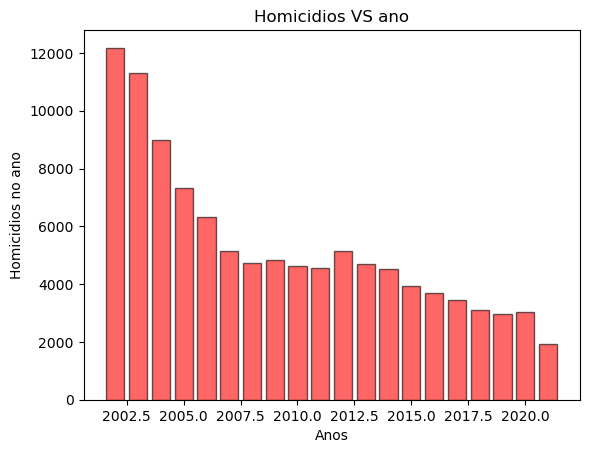

In [64]:
plt.bar(homicidio_estado.ano, homicidio_estado.Homicidio_total, edgecolor='black', color='red', alpha=0.6)
plt.xlabel('Anos')
plt.ylabel('Homicidios no ano')
plt.title('Homicidios VS ano')
plt.show()

 ## Então, deve-se entender as correlações entre as features e variáveis, para que seja possível diagnosticar futuros erros

Text(0.5, 1.0, 'Correlações')

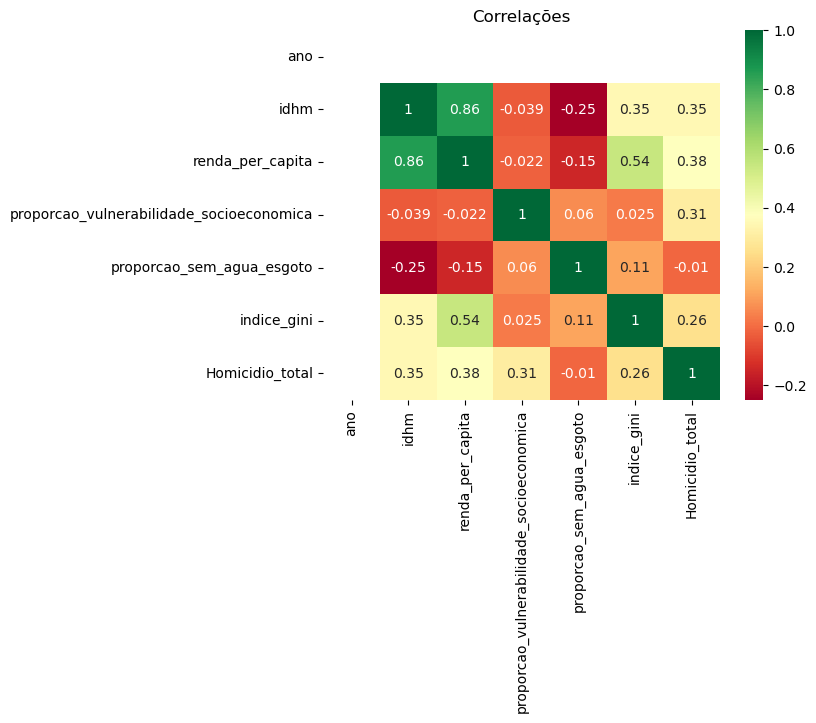

In [48]:
sns.heatmap(tabela_sem_sp.corr(), annot = True, cmap= "RdYlGn")
plt.title('Correlações')

# Por fim, plota-se os gráficos de dispersão + .corr

### Nota: Esses gráficos de dispersão são referentes ao ano 2010

Correlação entre homicídios e idhm é moderada e possui valor de 0.42771441557377515
Correlação entre homicídios e renda per capita é moderada e possui valor de 0.5322921691581864
Correlação entre homicídios e prop. de pessoas vulneráveis é fraca e possui valor de 0.01487766744202325
Correlação entre homicídios e prop. de pessoas sem esgoto é fraca e possui valor de 0.011407256663510076
Correlação entre homicídios e indice gini é moderada e possui valor de 0.31440106416117497


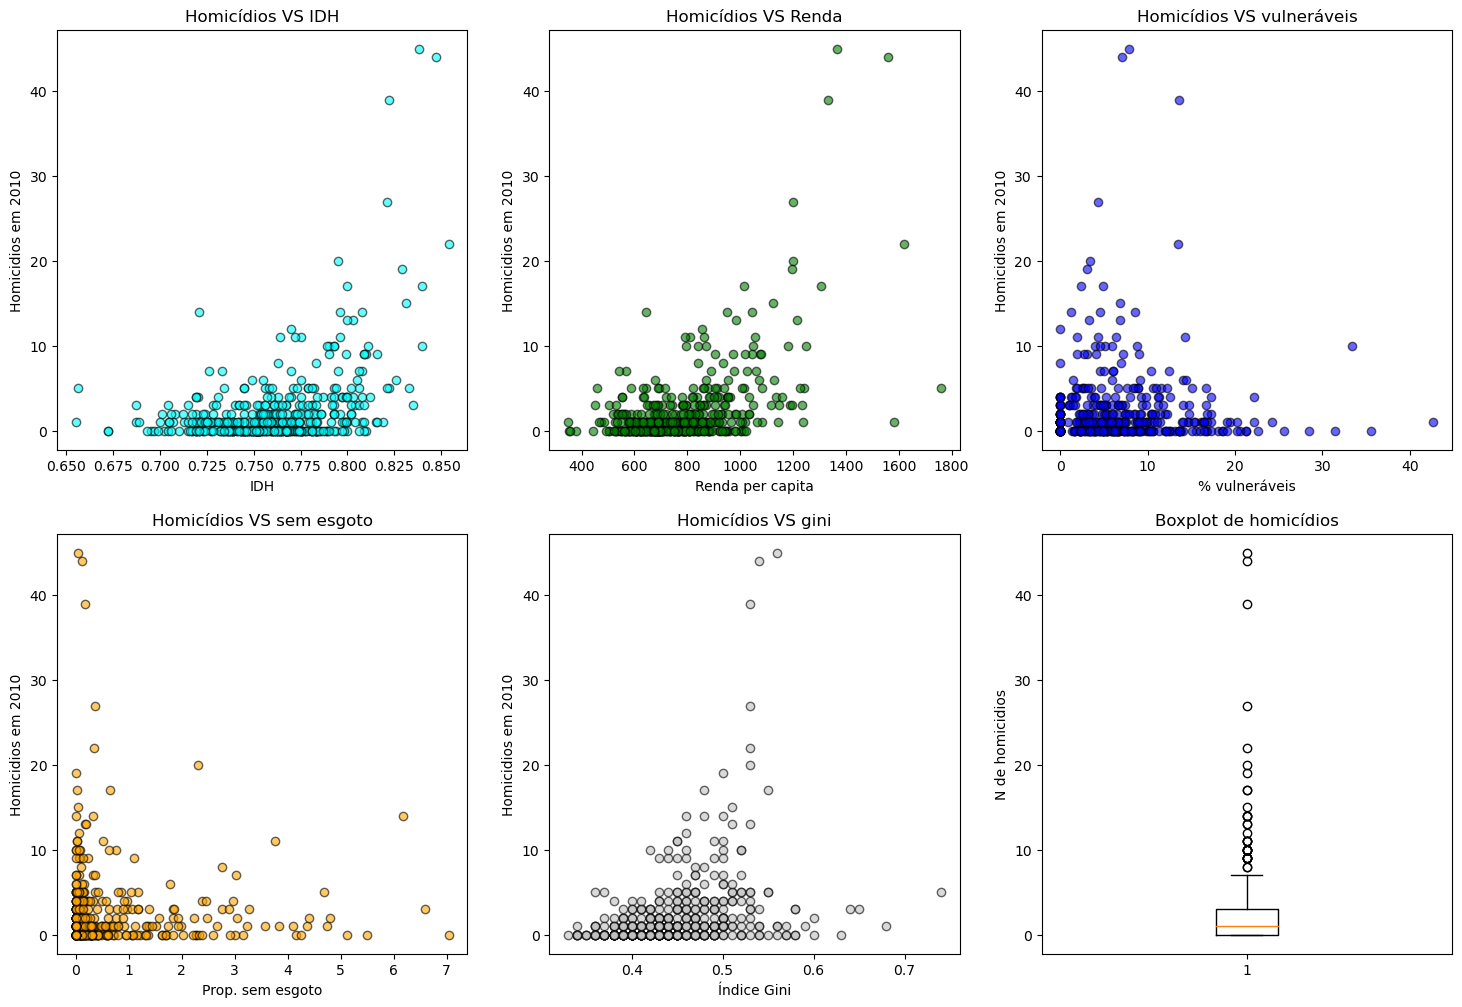

In [75]:
plt.figure(figsize=(18,12))

plt.subplot(2,3,1)
plt.scatter(df_treino['idhm'], df_treino['Homicidio_total'], alpha=0.6, color='cyan', edgecolors="black")
plt.xlabel('IDH')
plt.ylabel('Homicidios em 2010')
plt.title('Homicídios VS IDH')
corr_idhm = df_treino['Homicidio_total'].corr(df_treino['idhm'])
if abs(corr_idhm) < 0.3:
    print(f'Correlação entre homicídios e idhm é fraca e possui valor de {corr_idhm}')
elif abs(corr_idhm) >0.3 and (corr_idhm) < 0.7:
    print(f'Correlação entre homicídios e idhm é moderada e possui valor de {corr_idhm}')
elif abs(corr_idhm) > 0.7:
    print(f'Correlação entre homicídios e idhm é forte e possui valor de {corr_idhm}')

plt.subplot(2,3,2)
plt.scatter(df_treino['renda_per_capita'], df_treino['Homicidio_total'], alpha=0.6, color='green', edgecolors="black")
plt.xlabel('Renda per capita')
plt.ylabel('Homicidios em 2010')
plt.title('Homicídios VS Renda')
corr_renda = df_treino['Homicidio_total'].corr(df_treino['renda_per_capita'])
if abs(corr_renda) < 0.3:
    print(f'Correlação entre homicídios e renda per capita é fraca e possui valor de {corr_renda}')
elif abs(corr_renda) >0.3 and (corr_renda) < 0.7:
    print(f'Correlação entre homicídios e renda per capita é moderada e possui valor de {corr_renda}')
elif abs(corr_renda) > 0.7:
    print(f'Correlação entre homicídios e renda per capita é forte e possui valor de {corr_renda}')

plt.subplot(2,3,3)
plt.scatter(df_treino['proporcao_vulnerabilidade_socioeconomica'], df_treino['Homicidio_total'], alpha=0.6, color='blue', edgecolors="black")
plt.xlabel('% vulneráveis')
plt.ylabel('Homicidios em 2010')
plt.title('Homicídios VS vulneráveis')
corr_vul = df_treino['Homicidio_total'].corr(df_treino['proporcao_vulnerabilidade_socioeconomica'])
if abs(corr_vul) < 0.3:
    print(f'Correlação entre homicídios e prop. de pessoas vulneráveis é fraca e possui valor de {corr_vul}')
elif abs(corr_vul) >0.3 and (corr_vul) < 0.7:
    print(f'Correlação entre homicídios e prop. de pessoas vulneráveis é moderada e possui valor de {corr_vul}')
elif abs(corr_vul) > 0.7:
    print(f'Correlação entre homicídios e prop. de pessoas vulneráveis é forte e possui valor de {corr_vul}')

plt.subplot(2,3,4)
plt.scatter(df_treino['proporcao_sem_agua_esgoto'], df_treino['Homicidio_total'], alpha=0.6, color='Orange', edgecolors="black")
plt.xlabel('Prop. sem esgoto')
plt.ylabel('Homicidios em 2010')
plt.title('Homicídios VS sem esgoto')
corr_esg = df_treino['Homicidio_total'].corr(df_treino['proporcao_sem_agua_esgoto'])
if abs(corr_esg) < 0.3:
    print(f'Correlação entre homicídios e prop. de pessoas sem esgoto é fraca e possui valor de {corr_esg}')
elif abs(corr_esg) >0.3 and (corr_esg) < 0.7:
    print(f'Correlação entre homicídios e prop. de pessoas sem esgoto é moderada e possui valor de {corr_esg}')
elif abs(corr_esg) > 0.7:
    print(f'Correlação entre homicídios e prop. de pessoas sem esgoto é forte e possui valor de {corr_esg}')

plt.subplot(2,3,5)
plt.scatter(df_treino['indice_gini'], df_treino['Homicidio_total'], alpha=0.6, color='silver', edgecolors="black")
plt.xlabel('Índice Gini')
plt.ylabel('Homicidios em 2010')
plt.title('Homicídios VS gini')
corr_gini = df_treino['Homicidio_total'].corr(df_treino['indice_gini'])
if abs(corr_gini) < 0.3:
    print(f'Correlação entre homicídios e indice gini é fraca e possui valor de {corr_gini}')
elif abs(corr_gini) >0.3 and (corr_gini) < 0.7:
    print(f'Correlação entre homicídios e indice gini é moderada e possui valor de {corr_gini}')
elif abs(corr_gini) > 0.7:
    print(f'Correlação entre homicídios e indice gini é forte e possui valor de {corr_gini}')

plt.subplot(2,3,6)
plt.boxplot(df_treino['Homicidio_total'])
plt.title('Boxplot de homicídios')
plt.ylabel('N de homicidios')

plt.show()

## Possíveis fontes de erro!

### Ao analisarmos a função .agg observamos que ela fazia com que existisse alguns pontos aberrantes, por exemplo, em sp tinhamos 1260 homicídios. Logo, tiramos esse ponto aberrante e trabalharemos com essa possibilidade de erro para as próximas análises

## Agora iremos criar um modelo de regressão linear com múltiplas variáveis

In [21]:
def regress(Y,X):
    '''
    Y: coluna do DataFrame utilizada como variável resposta (TARGET)
    X: coluna(s) do DataFrame utilizadas como variável(is) explicativas (FEATURES)
    '''
    X_cp = sm.add_constant(X)
    model = sm.OLS(Y,X_cp)
    results = model.fit()
    
    return results

In [25]:
X = tabela_sem_sp[['idhm', 'renda_per_capita', 'proporcao_vulnerabilidade_socioeconomica', 'proporcao_sem_agua_esgoto', 'indice_gini']]

Y = tabela_sem_sp['Homicidio_total']

In [26]:
modelo_regress = regress(Y, X)

modelo_regress.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        Homicidio_total   R-squared:                       0.249
Model:                            OLS   Adj. R-squared:                  0.243
Method:                 Least Squares   F-statistic:                     41.93
Date:                Thu, 23 Nov 2023   Prob (F-statistic):           2.55e-37
Time:                        10:33:39   Log-Likelihood:                -2495.7
No. Observations:                 639   AIC:                             5003.
Df Residuals:                     633   BIC:                             5030.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
============================================================================================================
                                               coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------
const                                      -67.2958     20.487     -3.285      0.001    -107.526     -27.066
idhm                                        65.9522     28.902      2.282      0.023       9.196     122.708
renda_per_capita                             0.0119      0.005      2.614      0.009       0.003       0.021
proporcao_vulnerabilidade_socioeconomica     0.5657      0.063      9.046      0.000       0.443       0.689
proporcao_sem_agua_esgoto                    0.3905      0.414      0.942      0.346      -0.423       1.204
indice_gini                                 17.7038     10.170      1.741      0.082      -2.268      37.675
==============================================================================
Omnibus:                      804.967   Durbin-Watson:                   1.892
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           114627.831
Skew:                           6.217   Prob(JB):                         0.00
Kurtosis:                      67.425   Cond. No.                     6.21e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.21e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Então, precisamos analisar quais variáveis serão desejáveis para a análise. Para isso iremos utilizar um processo iterativo de rodar o modelo e avaliar se o valor P está acima de 10% (índice de significância), caso esteja, ele deverá ser retirado e rodaremos o modelo denovo até que achemos todas as variáveis relevantes.

In [27]:
X = tabela_sem_sp[['idhm', 'renda_per_capita', 'proporcao_vulnerabilidade_socioeconomica', 'indice_gini']] #retirando prop_agua_sem_esgoto

Y = tabela_sem_sp['Homicidio_total']

In [28]:
modelo_regress = regress(Y, X)

modelo_regress.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        Homicidio_total   R-squared:                       0.248
Model:                            OLS   Adj. R-squared:                  0.243
Method:                 Least Squares   F-statistic:                     52.20
Date:                Thu, 23 Nov 2023   Prob (F-statistic):           5.12e-38
Time:                        10:34:03   Log-Likelihood:                -2496.2
No. Observations:                 639   AIC:                             5002.
Df Residuals:                     634   BIC:                             5025.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
============================================================================================================
                                               coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------
const                                      -64.0010     20.184     -3.171      0.002    -103.637     -24.365
idhm                                        60.8229     28.382      2.143      0.032       5.088     116.558
renda_per_capita                             0.0120      0.005      2.641      0.008       0.003       0.021
proporcao_vulnerabilidade_socioeconomica     0.5683      0.062      9.097      0.000       0.446       0.691
indice_gini                                 19.3610     10.016      1.933      0.054      -0.308      39.030
==============================================================================
Omnibus:                      803.509   Durbin-Watson:                   1.878
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           113599.282
Skew:                           6.199   Prob(JB):                         0.00
Kurtosis:                      67.132   Cond. No.                     6.11e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.11e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Agora que apenas as features relevantes sobraram, devemos análisar a correlação entre os erros do modelo. Para isso, utilizaremos o valor de Durbin-Watson.

## No caso, esse valor é de 1,865

In [31]:
resultado = 2*(1-1.878)

In [32]:
resultado

-1.7559999999999998

## Como esse resultado está muito próximo de 2, pode-se afirmar que a correlação entre os erros é bem baixa !

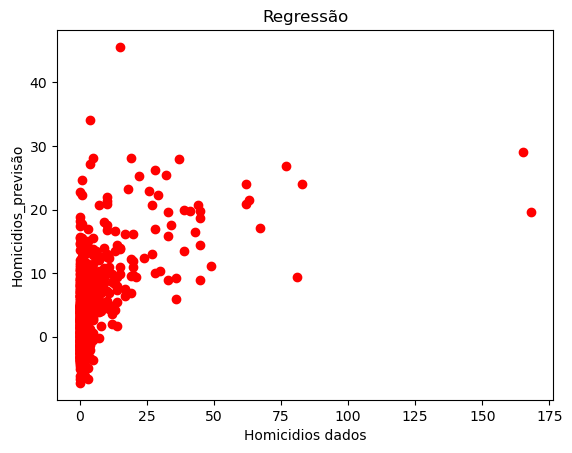

In [65]:
y = modelo_regress.predict()
plt.scatter(tabela_sem_sp.Homicidio_total, y, color = 'red')
plt.title('Regressão')
plt.ylabel('Homicidios_previsão')
plt.xlabel('Homicidios dados')
plt.show()